# Ad Sales Data
# Revenue Regression
Code link: https://www.kaggle.com/code/akshaysunil07/ad-tech-revenue-regression/notebook 

# Installing packages section

In [ ]:
# Installing packages set for without init script
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

In [ ]:
!pip install seaborn

# Restart and clear outputs

# Importing packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

Matplotlib created a temporary cache directory at /tmp/matplotlib-4w36ephm because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from fosforml import *
from fosforml.constants import MLModelFlavours
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar
from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

# Importing data from snowflake

In [3]:
from fosforio import snowflake
from fosforio import get_dataframe
snowflake.get_connection(connection_name="ME_AD_SALES_CXN")
df = get_dataframe("AD_SALES_IMP")
df_all = get_dataframe("AD_TECH_INPUT")

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.
Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7fa4bb3cbaf0>
Please close the connection after use!
Reading dataframe from snowflake native connector
Reading dataframe from snowflake native connector


df.info()

In [4]:
df.columns = df.columns.str.lower()
df_all.columns = df_all.columns.str.lower()
#df.info()

# Exploratory data analysis

In [5]:
cat_col=['date','geo_id','order_id','site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']
scat_col = ['site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']
num_col=list(df.select_dtypes(np.number).columns)

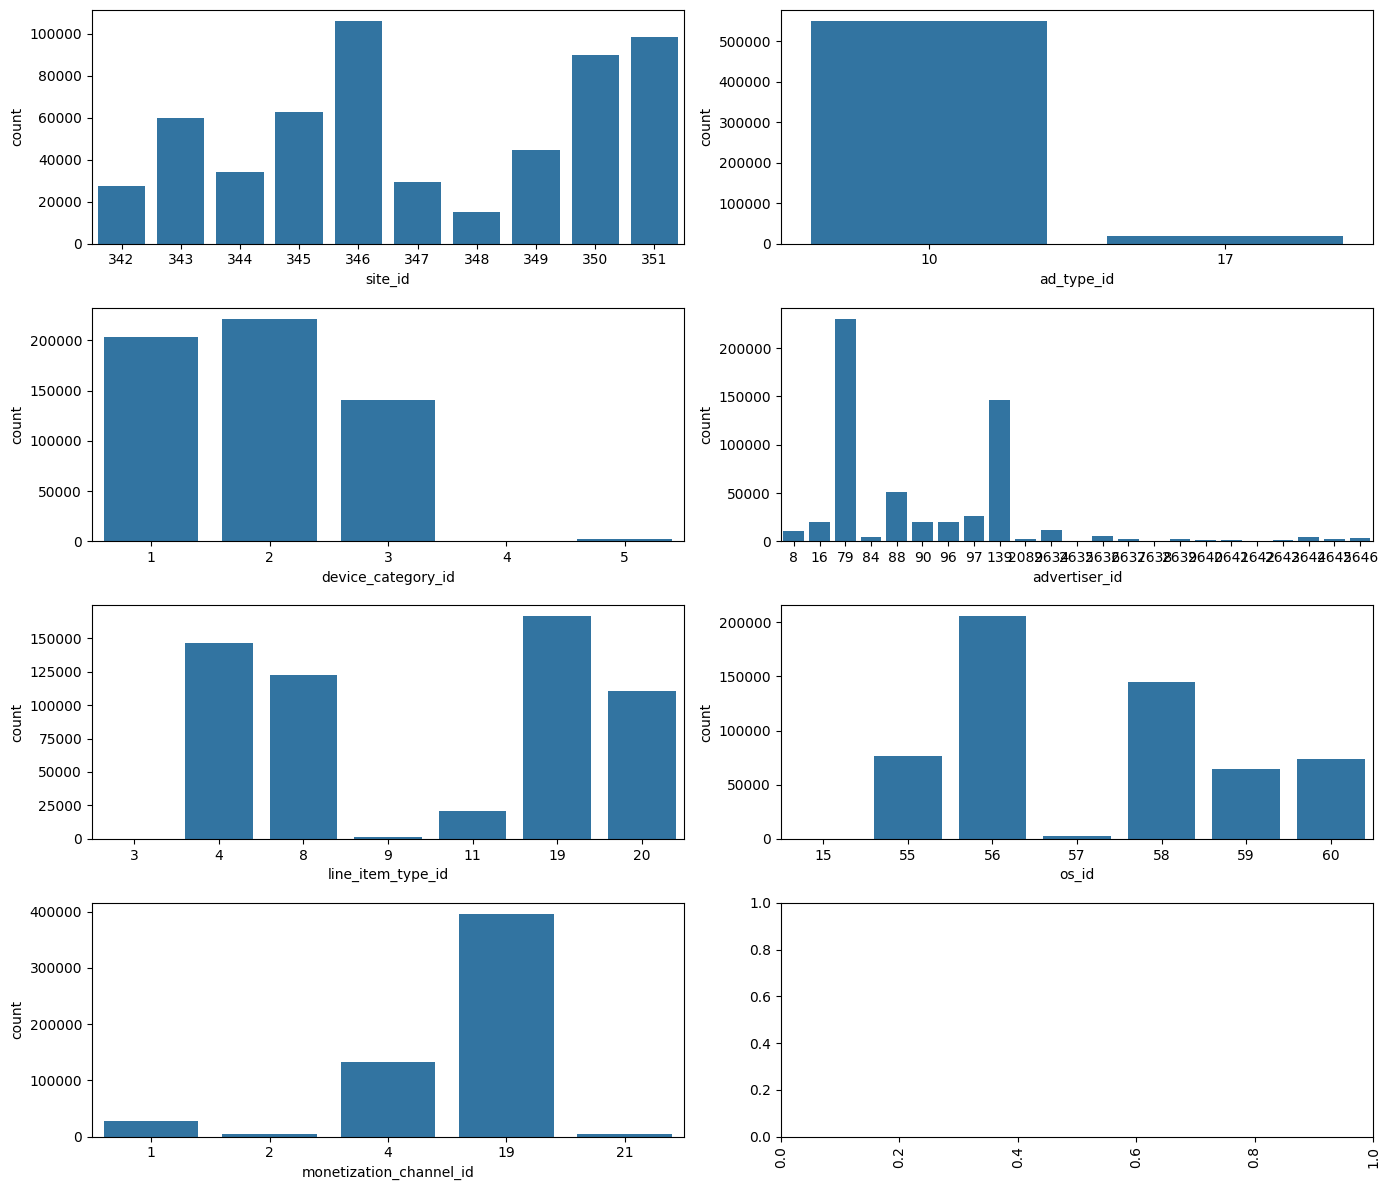

In [6]:
fig, ax = plt.subplots(4,2, figsize=(14,12))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i,col in enumerate(scat_col):
    sns.countplot(data=df,x=col,ax=axes_[i])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.tight_layout()

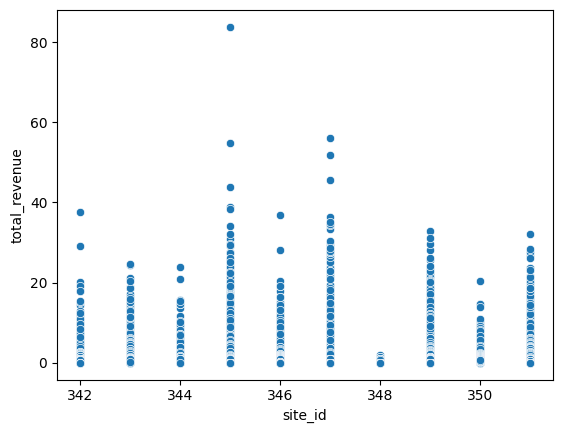

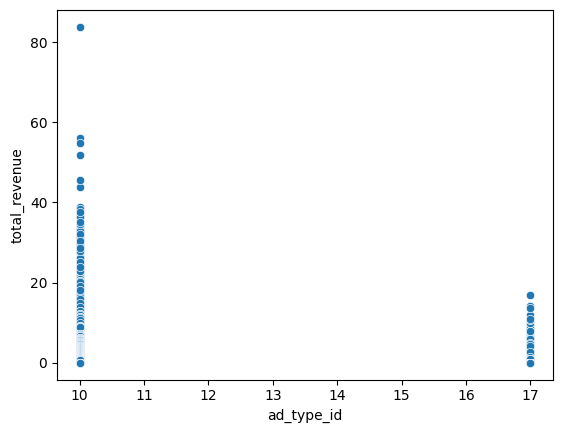

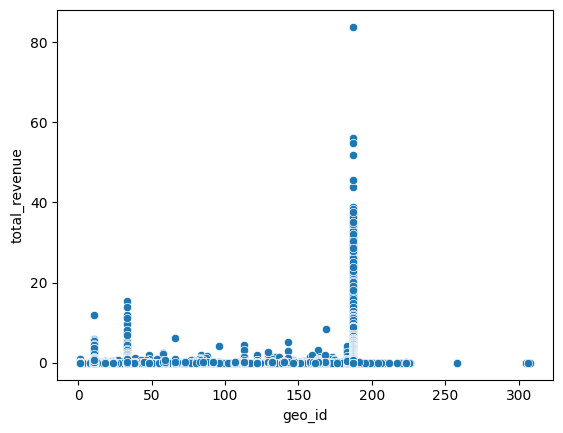

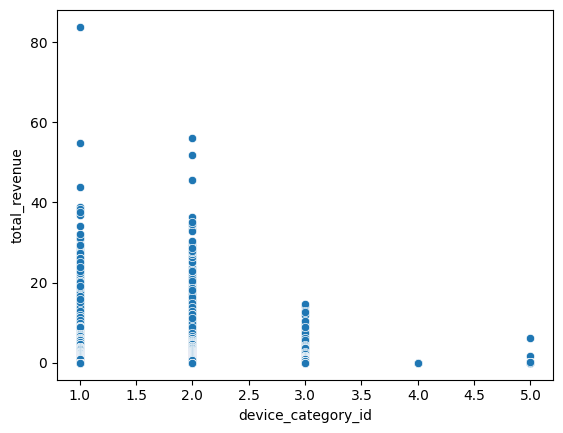

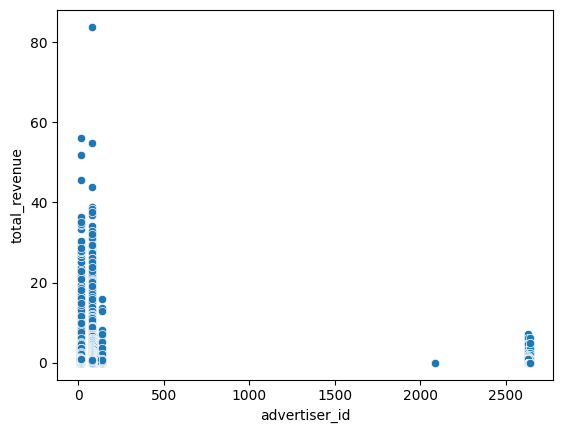

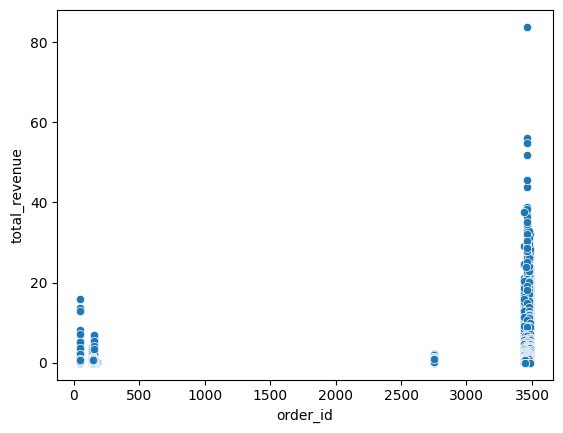

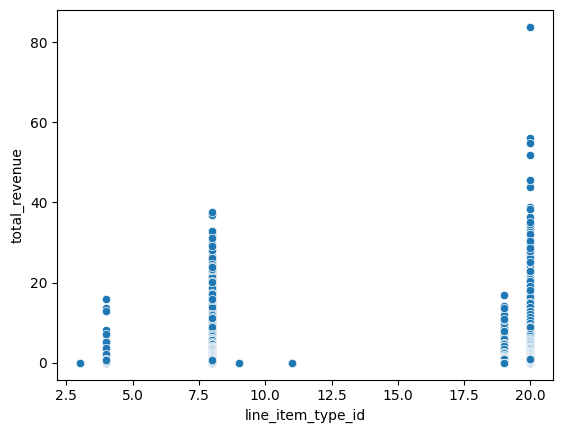

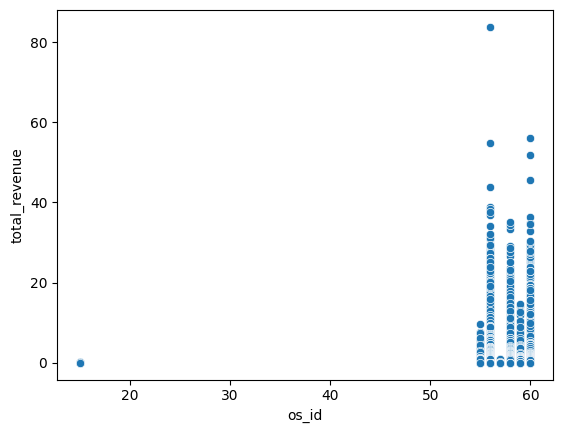

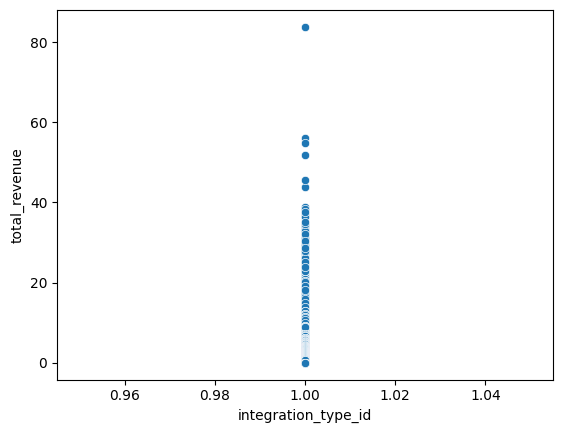

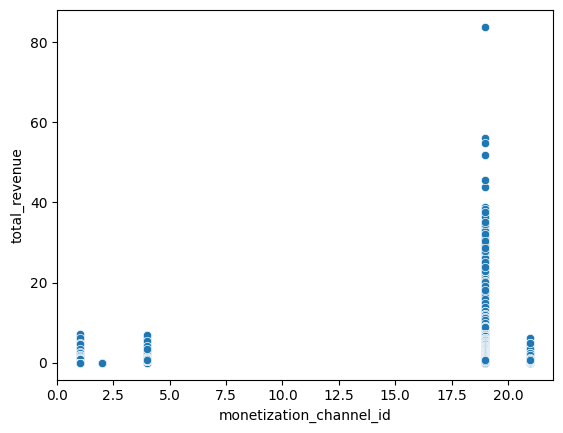

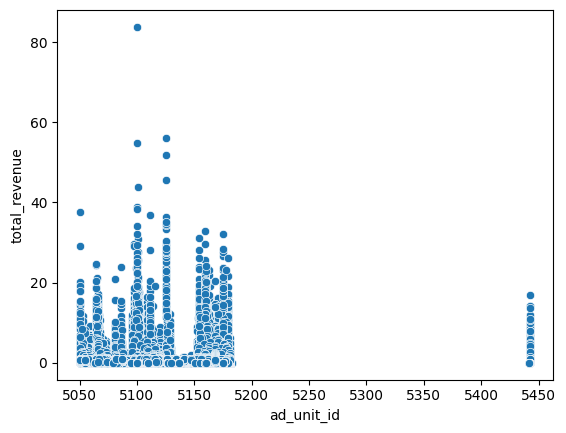

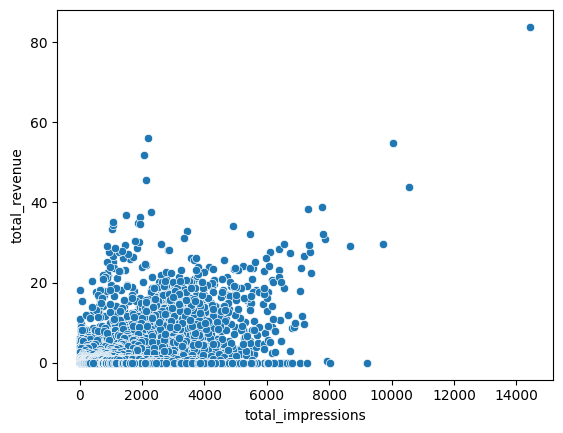

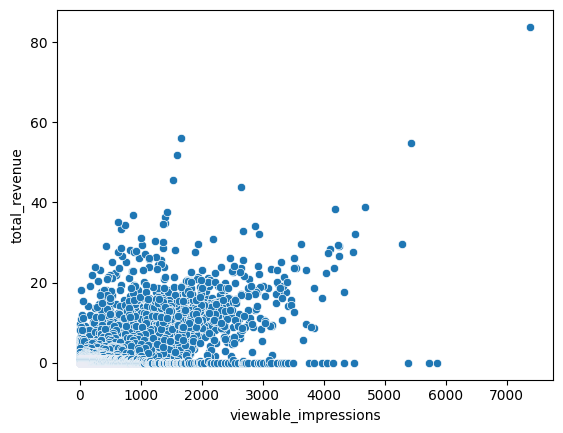

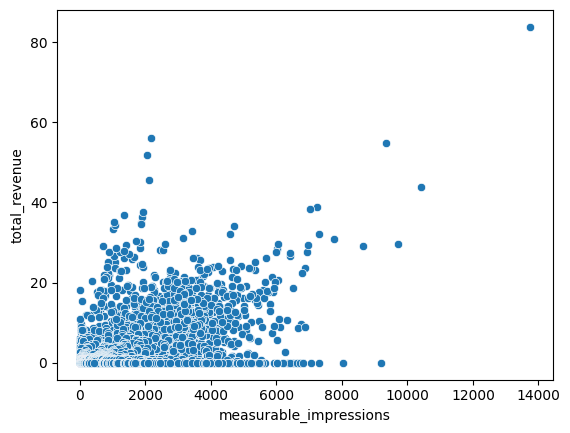

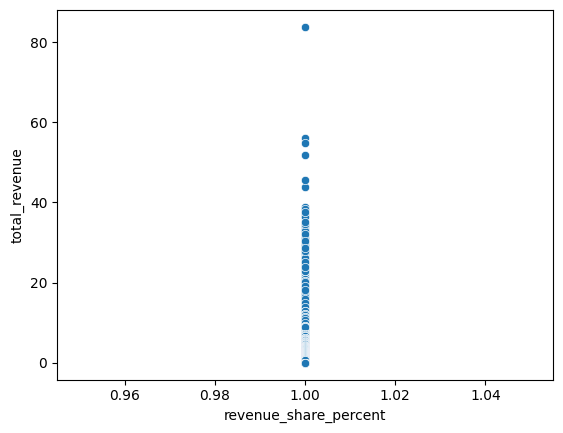

In [7]:
for i in num_col:
    if i!='total_revenue':
        sns.scatterplot(data=df,x=i,y='total_revenue')
        plt.show()

In [8]:
df.max()

date                       30-06-2024 00:00
site_id                                 351
ad_type_id                               17
geo_id                                  308
device_category_id                        5
advertiser_id                          2646
order_id                               3489
line_item_type_id                        20
os_id                                    60
integration_type_id                       1
monetization_channel_id                  21
ad_unit_id                             5443
total_impressions                     14452
total_revenue                        83.822
viewable_impressions                   7392
measurable_impressions                13756
revenue_share_percent                     1
dtype: object

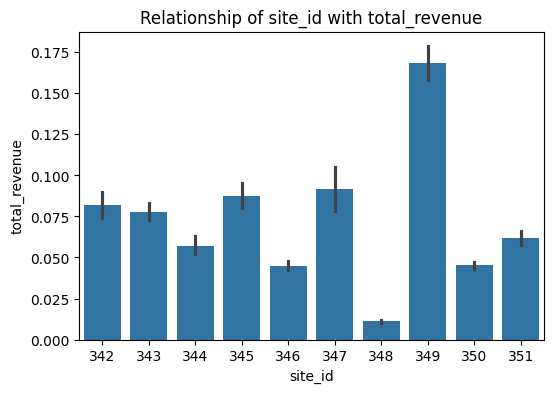

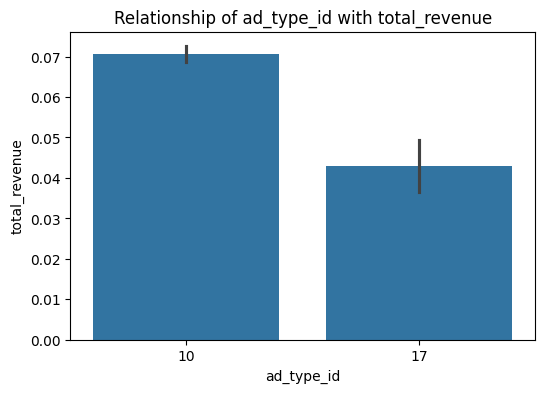

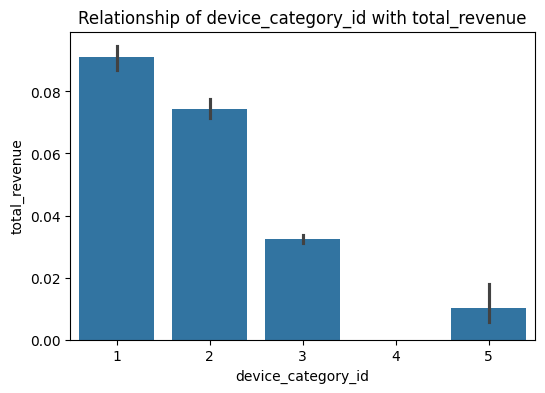

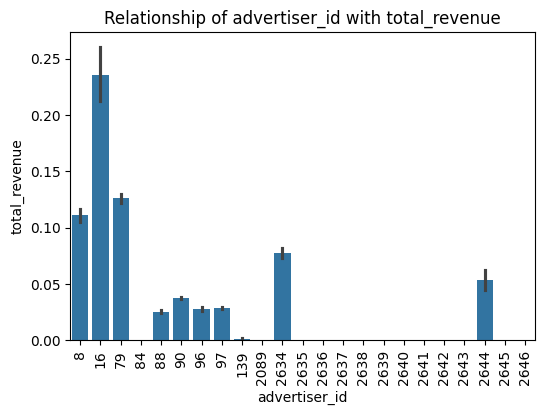

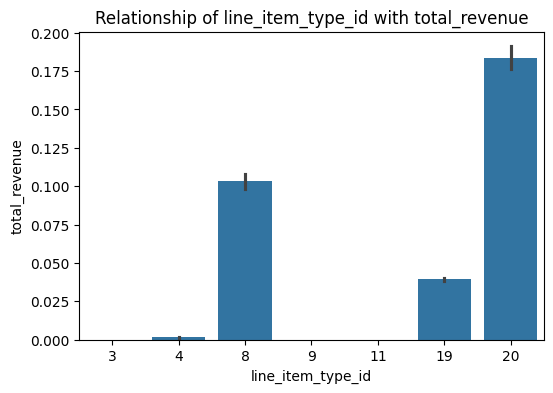

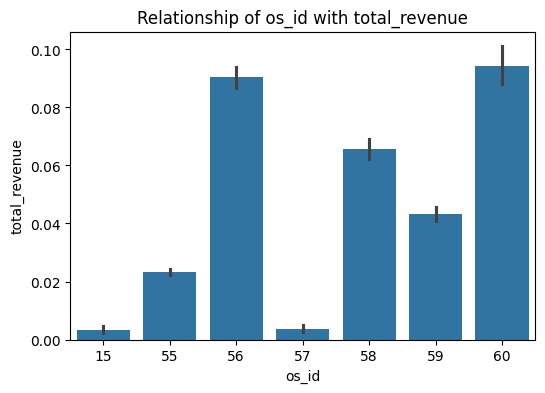

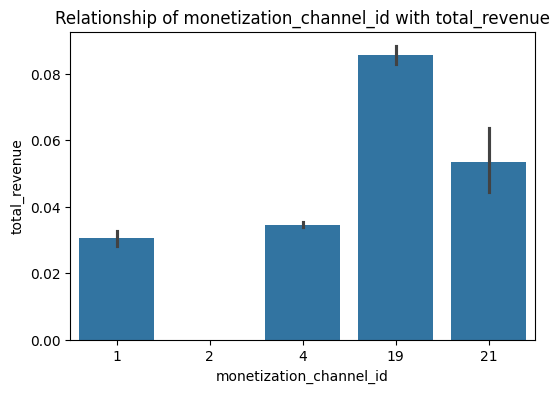

In [9]:
for col in (scat_col):
    title='Relationship of '+col+' with total_revenue'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_revenue'],x=df[col])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

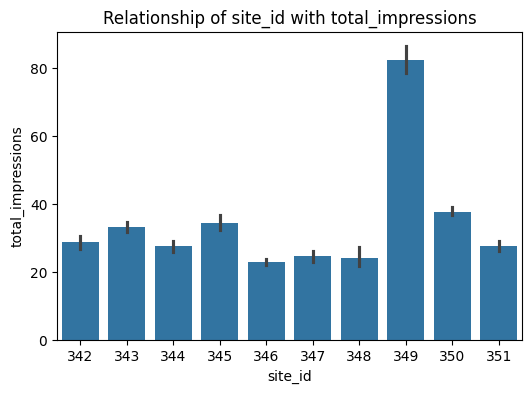

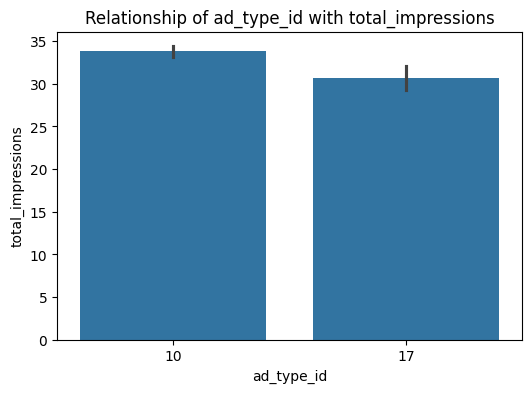

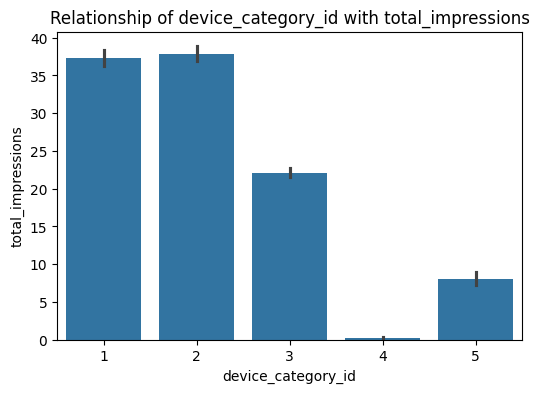

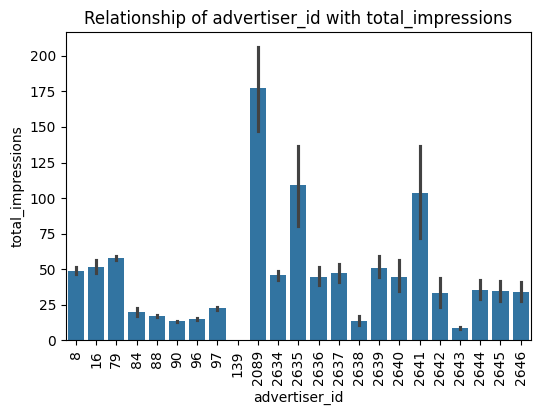

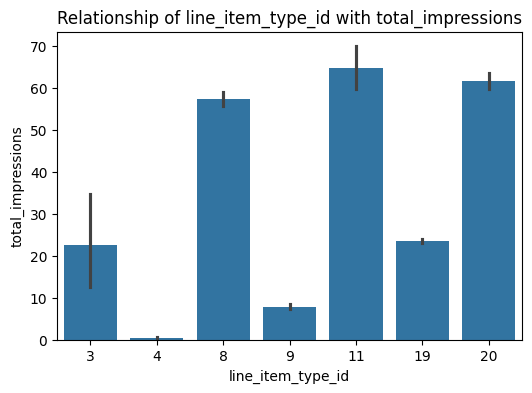

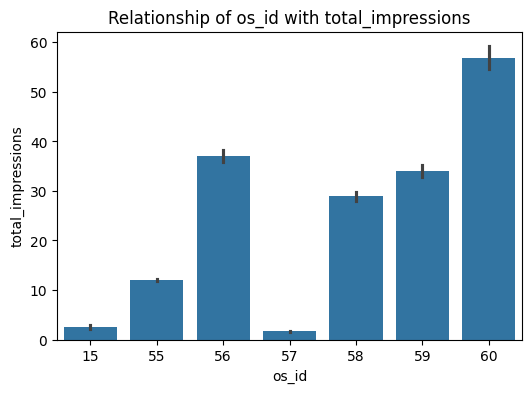

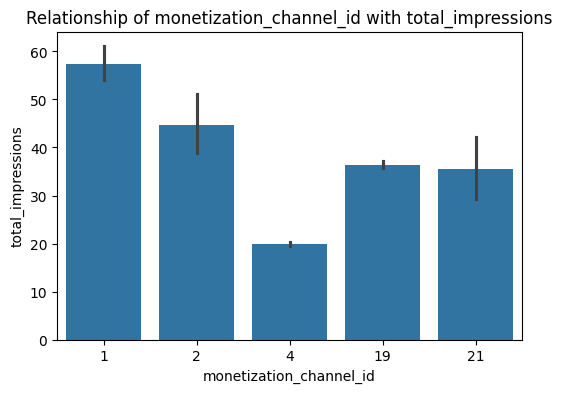

In [10]:
for col in (scat_col):
    title='Relationship of '+ col +' with total_impressions'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_impressions'],x=df[col],)
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

In [11]:
for i in cat_col:
    df[i]=df[i].astype('object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  object 
 2   ad_type_id               567291 non-null  object 
 3   geo_id                   567291 non-null  object 
 4   device_category_id       567291 non-null  object 
 5   advertiser_id            567291 non-null  object 
 6   order_id                 567291 non-null  object 
 7   line_item_type_id        567291 non-null  object 
 8   os_id                    567291 non-null  object 
 9   integration_type_id      567291 non-null  int8   
 10  monetization_channel_id  567291 non-null  object 
 11  ad_unit_id               567291 non-null  int16  
 12  total_impressions        567291 non-null  int16  
 13  total_revenue            567291 non-null  float64
 14  view

In [13]:
df.drop(['ad_unit_id','revenue_share_percent','integration_type_id','ad_type_id','site_id','advertiser_id',
        'date','geo_id','order_id'],axis=1,inplace=True)
df.select_dtypes(object)

,device_category_id,line_item_type_id,os_id,monetization_channel_id
0,2,19,58,4
1,2,19,60,4
2,2,19,58,4
3,3,20,59,19
4,3,20,59,19
...,...,...,...,...
567286,1,11,56,1
567287,1,11,56,1
567288,1,11,56,1
567289,2,11,60,1


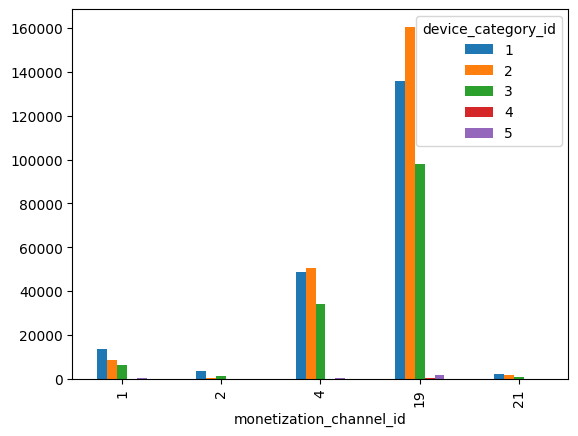

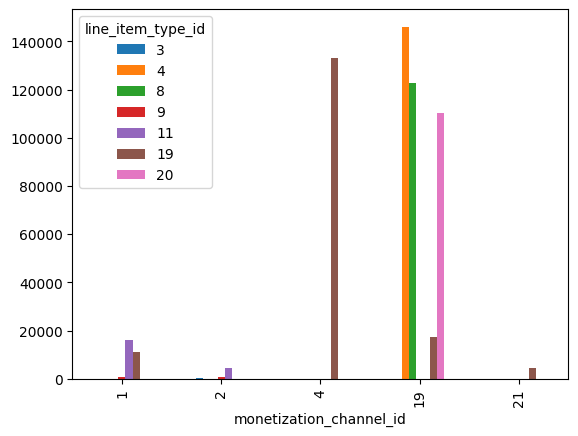

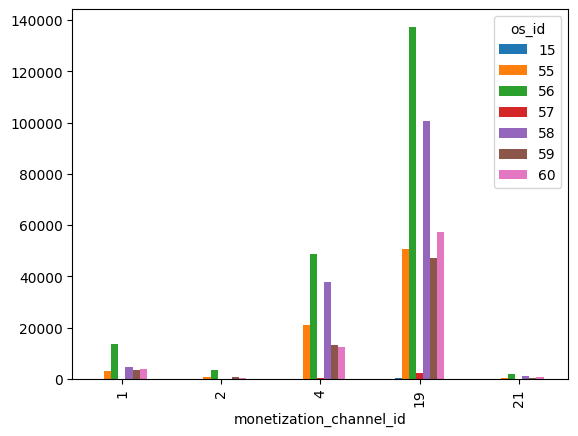

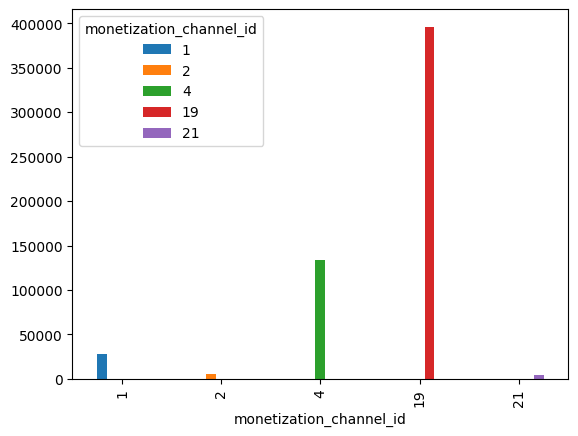

In [14]:
for i in df.select_dtypes(object).columns:
    pd.crosstab(df['monetization_channel_id'],df[i]).plot(kind='bar')
    plt.show()

# Predictive Modelling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   device_category_id       567291 non-null  object 
 1   line_item_type_id        567291 non-null  object 
 2   os_id                    567291 non-null  object 
 3   monetization_channel_id  567291 non-null  object 
 4   total_impressions        567291 non-null  int16  
 5   total_revenue            567291 non-null  float64
 6   viewable_impressions     567291 non-null  int16  
 7   measurable_impressions   567291 non-null  int16  
dtypes: float64(1), int16(3), object(4)
memory usage: 24.9+ MB


In [16]:
Xd = df.drop('total_revenue',axis=1)
y = df['total_revenue']

In [17]:
X = pd.get_dummies(Xd,drop_first=True)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   total_impressions           567291 non-null  int16
 1   viewable_impressions        567291 non-null  int16
 2   measurable_impressions      567291 non-null  int16
 3   device_category_id_2        567291 non-null  bool 
 4   device_category_id_3        567291 non-null  bool 
 5   device_category_id_4        567291 non-null  bool 
 6   device_category_id_5        567291 non-null  bool 
 7   line_item_type_id_4         567291 non-null  bool 
 8   line_item_type_id_8         567291 non-null  bool 
 9   line_item_type_id_9         567291 non-null  bool 
 10  line_item_type_id_11        567291 non-null  bool 
 11  line_item_type_id_19        567291 non-null  bool 
 12  line_item_type_id_20        567291 non-null  bool 
 13  os_id_55                    567291 non-null 

In [19]:
pc_col = ['total_impressions', 'viewable_impressions', 'measurable_impressions']

In [20]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [21]:
X[pc_col] = pd.DataFrame(ss.fit_transform(X[pc_col]),columns=[pc_col])

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

# Applying PCA (principal component analysis)

In [23]:
from sklearn.decomposition import PCA
pc_col=['total_impressions', 'viewable_impressions', 'measurable_impressions']
pca = PCA()
pca.fit(X[pc_col])

PCA()

In [24]:
np.cumsum(pca.explained_variance_ratio_)

array([0.94556992, 0.99831945, 1.        ])

In [25]:
pca = PCA(n_components=1)
cc = pca.fit_transform(X_train[pc_col])
cd = pca.transform(X_test[pc_col])

In [26]:
X_train['PC']=cc
X_test['PC']=cd

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453832 entries, 250056 to 485815
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   total_impressions           453832 non-null  float64
 1   viewable_impressions        453832 non-null  float64
 2   measurable_impressions      453832 non-null  float64
 3   device_category_id_2        453832 non-null  bool   
 4   device_category_id_3        453832 non-null  bool   
 5   device_category_id_4        453832 non-null  bool   
 6   device_category_id_5        453832 non-null  bool   
 7   line_item_type_id_4         453832 non-null  bool   
 8   line_item_type_id_8         453832 non-null  bool   
 9   line_item_type_id_9         453832 non-null  bool   
 10  line_item_type_id_11        453832 non-null  bool   
 11  line_item_type_id_19        453832 non-null  bool   
 12  line_item_type_id_20        453832 non-null  bool   
 13  os_id_55      

In [28]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113459 entries, 542543 to 94897
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   total_impressions           113459 non-null  float64
 1   viewable_impressions        113459 non-null  float64
 2   measurable_impressions      113459 non-null  float64
 3   device_category_id_2        113459 non-null  bool   
 4   device_category_id_3        113459 non-null  bool   
 5   device_category_id_4        113459 non-null  bool   
 6   device_category_id_5        113459 non-null  bool   
 7   line_item_type_id_4         113459 non-null  bool   
 8   line_item_type_id_8         113459 non-null  bool   
 9   line_item_type_id_9         113459 non-null  bool   
 10  line_item_type_id_11        113459 non-null  bool   
 11  line_item_type_id_19        113459 non-null  bool   
 12  line_item_type_id_20        113459 non-null  bool   
 13  os_id_55       

In [29]:
X_train.drop(pc_col,axis=1,inplace=True)
X_test.drop(pc_col,axis=1,inplace=True)

# Model 1: Linear Regression (SKIP run)

In [30]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [31]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error

In [ ]:
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)

print('Model 1: Linear regression')
print('Train')
print('R2 Score:',r2_score(y_train,y_train_pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(y_train,y_train_pred))

y_test_pred=lr.predict(X_test)

print('\n\nTest')
print('R2 Score:',r2_score(y_test,y_test_pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(y_test,y_test_pred))

# Model 2: Random Forest (Run from HERE)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()

rfr.fit(X_train,y_train)
y_train_pred=rfr.predict(X_train)

print('Model 2: Random forest regression- plain')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
rfrbest1 = {'max_depth': 12,
 'max_features': 8,
 'min_samples_leaf': 3,
 'n_estimators': 160}

In [ ]:
rfr1 = RandomForestRegressor(**rfrbest1)

rfr1.fit(X_train,y_train)
y_train_pred=rfr1.predict(X_train)

print('Model 3: Random forest regression- best 1')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr1.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
# rfr = RandomForestRegressor() 
#param_dist = {'n_estimators':sp_randint(25,250), 'max_features':sp_randint(1,24), 'max_depth':sp_randint(2,15), 
#                                                                'min_samples_leaf':sp_randint(1,50)} rsearch = RandomizedSearchCV(rfr,param_distributions=param_dist,scoring='r2', 
#                                                                  n_iter=10,cv=3,n_jobs=-1,random_state=4) rsearch.fit(X_train,y_train) rsearch.best_params_

In [ ]:
rfrbest2 = {'max_depth': 12,
 'max_features': 15,
 'min_samples_leaf': 6,
 'n_estimators': 154}

In [ ]:
rfr2 = RandomForestRegressor(**rfrbest2)

rfr2.fit(X_train,y_train)
y_train_pred = rfr2.predict(X_train)

print('Model 4: Random forest regression- best 2')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred = rfr2.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
#Snce RFR1 is good, Im using that model:
rfr1 = RandomForestRegressor(**rfrbest1)

rfr1.fit(X_train,y_train)
y_train_pred=rfr1.predict(X_train)

print('Model 3: Random forest regression- best 1')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr1.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
X.info()

In [ ]:
X_train.info()

In [ ]:
y_df= pd.DataFrame(y)
y_df.info()

In [ ]:
y_train_df= pd.DataFrame(y_train)
y_train_df

In [ ]:
y_test_df= pd.DataFrame(y_test)
y_test_df

In [ ]:
y_test_df.info()

In [ ]:
y_train_pred_df = pd.DataFrame(y_train_pred, columns=['y_pred'])
y_train_pred_df

In [ ]:
y_test_pred_df = pd.DataFrame(y_test_pred,columns=['y_pred'])
y_test_pred_df

In [ ]:
y_train_final= pd.concat([y_train_df, y_train_pred_df.set_index(y_train_df.index)], axis=1)
y_train_final

In [ ]:
y_test_final= pd.concat([y_test_df, y_test_pred_df.set_index(y_test_df.index)], axis=1)
y_test_final

In [ ]:
y_all = pd.concat([y_train_final, y_test_final])
y_all

In [ ]:
y_all.sort_index(axis=0, inplace = True)
y_all

In [ ]:
y_all.info()

In [ ]:
df_all

In [ ]:
check1 = pd.concat([df_all, y_all], axis = 1)
check1

In [ ]:
print(check1['y_pred'].sum())

In [ ]:
print(check1['total_revenue'].sum())

In [ ]:
check1= check1.rename(columns={"total_revenue": "tot-rev"})
check1.info()

In [ ]:
y_train_bkp = y_train_df.copy()
y_train_df.reset_index(drop=True, inplace=True)
y_train_df

In [ ]:
y_train.info()

In [ ]:
y_train_all = pd.concat([y_train_df,y_train_pred_df],axis = 1)
y_train_all

In [ ]:
y_train_final = pd.merge(y_train_bkp, y_train_all, on='total_revenue')
y_train_final

In [ ]:
y_train_pred_df = pd.DataFrame(y_train_pred)  
y_test_pred_df = pd.DataFrame(y_test_pred)  

In [ ]:
y_train

In [ ]:
y_train_df = pd.DataFrame(y_train)  

In [ ]:
y_train_club = pd.concat([y_train_df,y_train_pred_df])
y_train_club

In [ ]:
X_train

In [ ]:
train_df = X_train.copy()

In [ ]:
train_df['pred'] = y_train_pred_df

In [ ]:
train_df

In [ ]:
X_train

In [ ]:
rfr.predict(X_train.iloc[:4])

In [ ]:
df_out = pd.merge(X_train,y_train_pred_df, how = 'left',left_index = True, right_index = True)
df_out.

In [ ]:
df_out.shape

In [ ]:
train_df = pd.concat([X_train, y_train,y_train_pred_df])
test_df = pd.concat([X_test, y_test,y_test_pred_df])


In [ ]:
train_df.info()